In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import math

import logging

In [2]:
# riverstation_id = 1
# river = all_levels[all_levels['riverstation_id'] == riverstation_id]['level'].values

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)


# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# useful functions
def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]


def create_datasets(dataset, look_back=1, look_ahead=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-look_ahead+1):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back + look_ahead -1, 0])
    return np.array(data_x), np.array(data_y)


def reverse_scale(data, mean, std):
    # scaling revert
    for x in np.nditer(data, op_flags=['readwrite']):
        x[...] = x*std + mean
    return data


def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

def plotting(test, pred, step_ahead, score, score_name="MAPE"):
    plt.figure(figsize=(15,10))
    plt.subplot(1,1,1)
    plt.plot(test_y, label="Observed")
    plt.plot(pred_test, color="red", label=f"Predicted, {score_name}: {score:.5}%")
    plt.title(f"{step_ahead} step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.show()
            

In [4]:
# PARAMETERS
# ----------
split = 0.7
look_back = 72
results = []

# filling nans
data_fixed = data.groupby(lambda x: x.weekofyear)\
                 .transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6]\
                       .values\
                       .astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]
look_ahead_collection = [24, 48, 72]
look_ahead_collection = [24]


| N=700 | look_back=170 | look_ahead=72 | X=(16800, 1) |
| standarizing | mean=1.2539535714285714 | std=0.6859832203836762 |
| spliting test-train | test=((4799, 170), (4799,)) | train=((11519, 170), (11519,)) |


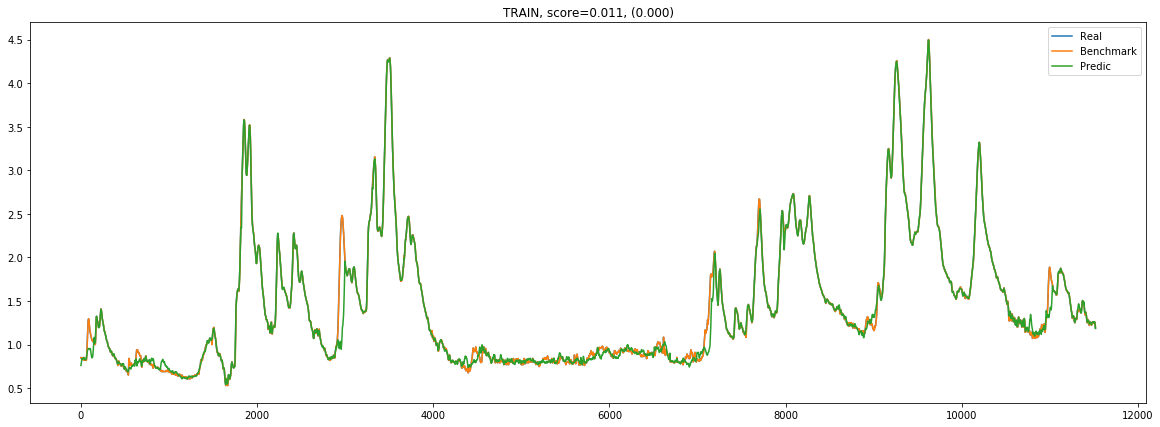

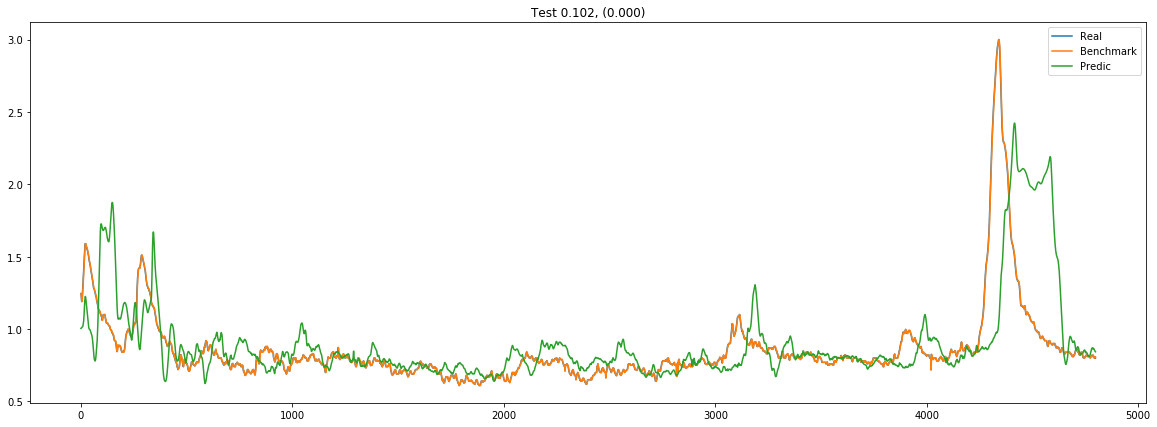

In [5]:
from collections import defaultdict
score = defaultdict(list)

# for look_back in range(6, 200, 12):
# for N in range(160, 600, 100):
N = 700
look_back = 170
look_ahead = 72


svr = SVR(C=1.0, epsilon=0.01, gamma=0.1, kernel="rbf", verbose=False, cache_size=1000)
river = all_levels[:N*24, [5]] # np.diff(all_levels[:N*24, [5]], axis=0)

print(f"| N={N} | look_back={look_back} | look_ahead={look_ahead} | X={river.shape} |")

# STANDARDIZE DATA
# ----------------
river_mean, river_std = river.mean(), river.std()
print(f"| standarizing | mean={river_mean} | std={river_std} |")
river = preprocessing.scale(river).reshape(len(river), 1)

# SPLIT TEST TRAIN
# ----------------
train, test = train_test_split(river, split)
train_x, train_y = create_datasets(train, look_back, look_ahead)
test_x, test_y = create_datasets(test, look_back, look_ahead)
print(f"| spliting test-train | test={test_x.shape, test_y.shape} | train={train_x.shape, train_y.shape} |")
svr.fit(train_x, train_y) 

# TRAIN
# -----
train_pred = svr.predict(train_x)
train_y = reverse_scale(train_y, river_mean, river_std)
train_yhat = reverse_scale(train_pred, river_mean, river_std)
train_bench = pd.DataFrame(train_y).shift().bfill().values

# SCORE
# -----
score_train_bench = mean_squared_error(train_y, train_bench)
score_train = mean_squared_error(train_y, train_yhat)

plt.figure(figsize=(20, 7))
plt.plot(train_y, label="Real")
plt.plot(train_bench, label="Benchmark")
plt.plot(train_yhat, label="Predic")
plt.legend()
plt.title(f"TRAIN, score={score_train:.3f}, ({score_train_bench:.3f})")
plt.show()

# TEST
# ----
test_pred = svr.predict(test_x)
test_y = reverse_scale(test_y, river_mean, river_std)
test_yhat = reverse_scale(test_pred, river_mean, river_std)
test_bench = pd.DataFrame(test_y).shift().bfill().values

score_test = mean_squared_error(test_y, test_yhat)
score_test_bench = mean_squared_error(test_y, test_bench)

score["N"].append(N)
score["score_train"].append(score_train)
score["score_test"].append(score_test)

plt.figure(figsize=(20, 7))
plt.plot(test_y, label="Real")
plt.plot(test_bench, label="Benchmark")
plt.plot(test_yhat, label="Predic")
plt.title(f"Test {score_test:.3f}, ({score_test_bench:.3f})")
plt.legend()
plt.show()

/Users/mmngreco/miniconda3/envs/river/lib/python3.6/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=700.0, right=700.0
  ax.set_xlim(left, right)


,N,score_train,score_test
0,700,0.00004,0.000064


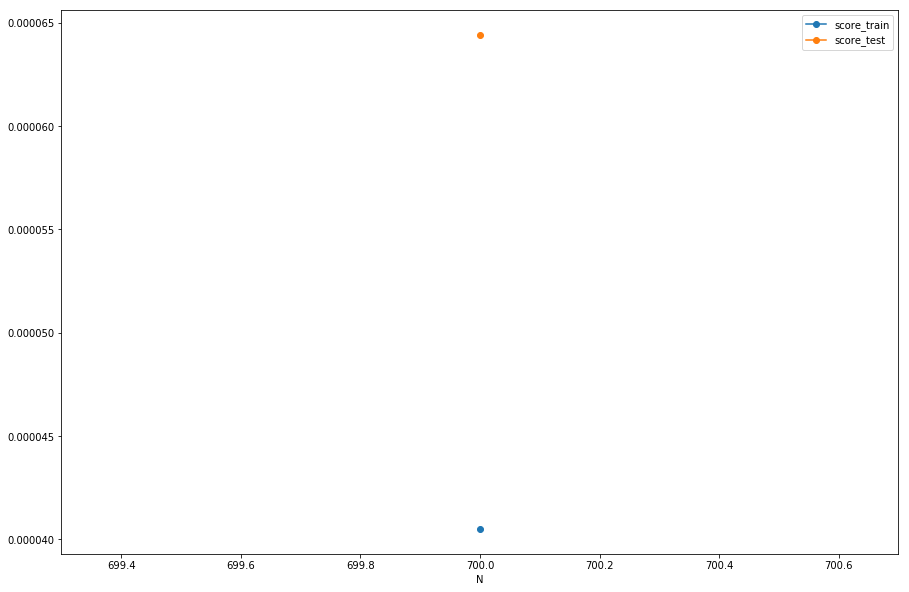

In [111]:
score_df = pd.DataFrame(score)
score_df.set_index("N").plot(marker="o")
score_df

| river_id=5 | river_name=ZGZ_NR | look_ahead=24 |
| standarizing | mean=1.2613107943164747 | std=0.7251103241897101 |
| spliting test-train | test=((28662, 72), (28662,)) | train=((67004, 72), (67004,)) |
| modeling SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=True) |
[LibSVM]| predicting set x | SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=True) |
| predicting set y | SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=True) |
| reverting scale |
| evaluating | 64965.46239378151 |


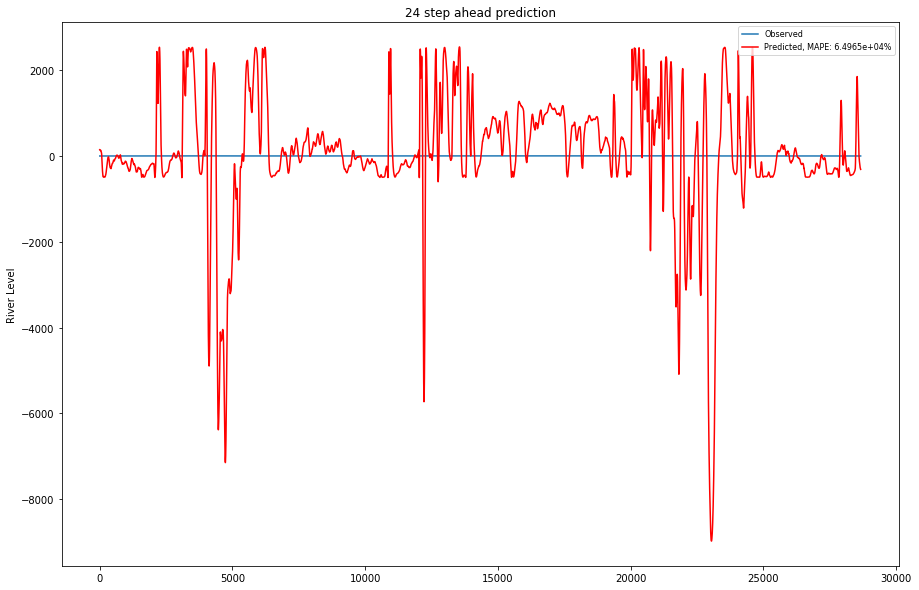

[[64965.46239378151]]


In [9]:
results_df = pd.DataFrame(results, index=names[river_i_list], columns=[24,48,72])
results_df.columns.name = "look_ahead"
results_df.index.name = "station"
results_df["mean"] = results_df.mean(axis=1)
results_df

look_ahead,24,48,72,mean
station,,,,
ZGZ_NR,4.797696,8.299351,10.412292,7.836447


In [12]:
import pickle

with open("SVR_78_1.pkl", "wb") as f:
    pickle.dump(clf, f)
